In [1]:
import scipy
import math
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn
import torch
from torch.optim import Adam
from torch.nn.functional import tanh, one_hot, relu
from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder, LabelEncoder
from sklearn.datasets import fetch_openml

In [2]:
use_mnist = False

if(use_mnist):
    mnist = fetch_openml('mnist_784')
    X, y = mnist.data.to_numpy(), mnist.target.to_numpy()
    X = X/256
else:
    digits = sklearn.datasets.load_digits()
    X, y = digits.data, digits.target
    X = X/16
    
x_train, x_test,y_train, y_test = sklearn.model_selection.train_test_split(X, y, 
                                        test_size = .1, random_state = 47)


In [3]:
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

In [4]:
modified = True

peekX = 10
peekY = 10

# Dimensions of each image
datx = int(math.sqrt(np.shape(X[0])[0]))
daty = int(math.sqrt(np.shape(X[0])[0]))

#Number of weights
dim = 100
dim = max(dim, peekX*peekY)



#Input and output dimensions
idim = np.shape(X[0])[0]
odim = 10

#Other model parameters
p = 3
k = 3
delta = .4
if(modified):
    delta = min(delta, .5/k)
n = 4.5
m = 2
R=1

#Training parameters
train_size = np.shape(x_train)[0]
test_size = np.shape(x_test)[0]
Nepochs = 100
batch_size = 100
epsmax = .04

<Figure size 432x288 with 0 Axes>

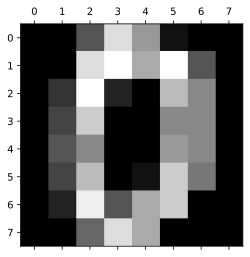

In [5]:
def look(X):
    plt.gray()
    plt.matshow(np.asmatrix(np.reshape(X, (datx,daty))))
    plt.show()
look(X[0])

In [6]:
def peek_weights(datx, daty, peekX, peekY, weights):
    fig=plt.figure(figsize=(12.9,10))
    fulmat = np.zeros((datx*peekX,daty*peekY))
    for i in range(peekX):
        for j in range(peekY):
            fulmat[i*datx:i*datx+datx,j*daty:j*daty+daty] = np.reshape(weights[peekY*i+j], (datx,daty))
    im = plt.imshow(fulmat, cmap = 'bwr')
    fig.colorbar(im,ticks=[np.amin(fulmat), 0, np.amax(fulmat)])
    plt.axis('off')
    return

def peek_weights_multiple(datx, daty, peekX, peekY, hid_layers, cwd):
    for k, hid in enumerate(hid_layers):
        fig=plt.figure(figsize=(12.9,10))
        fulmat = np.zeros((datx*peekX,daty*peekY))
        for i in range(peekX):
            for j in range(peekY):
                fulmat[i*datx:i*datx+datx,j*daty:j*daty+daty] = np.reshape(cwd[k][peekY*i+j], (datx,daty))
        im = plt.imshow(fulmat, cmap = 'bwr')
        fig.colorbar(im,ticks=[np.amin(fulmat), 0, np.amax(fulmat)])
        plt.axis('off')
    return

def vec_prod(x, w, p):
    return np.dot(np.sign(w)*np.absolute(w)**(p-1), np.transpose(x))

In [7]:
def unsuperv_fast(x_train, y_train, in_dim, out_dim):
    #initialize weights
    weights = np.random.normal(0, 1, (out_dim, in_dim))
    for epochs in range(Nepochs):
        eps = epsmax*(1-epochs/Nepochs)
        x_train, y_train = sklearn.utils.shuffle(x_train, y_train)
        for i in range (train_size//batch_size):
            x_batch = x_train[batch_size*i:batch_size*(i+1),:]
            
            #Fast implementation
            inp_lay = vec_prod(x_batch, weights, p)
                   
            argkey = np.argsort(inp_lay, axis = 0)#Should this be 1?
            gfunc = np.zeros((out_dim, batch_size))
            
            gfunc[argkey[out_dim-1,:], np.arange(batch_size)]=1
            if(modified):
                for i in range(k-1):
                    argkey[out_dim-1-i]
            gfunc[argkey[out_dim-k-1,:], np.arange(batch_size)]= -1*delta
            
            gim = np.sum(np.multiply(gfunc,inp_lay), axis = 1)
            v = R**p*np.dot(gfunc, x_batch)-np.multiply(np.outer(gim, np.ones(in_dim)), weights)
            
            trans = sklearn.preprocessing.MaxAbsScaler()
            trans.fit(v)
            weights += eps*trans.transform(v)
            
    return weights

In [8]:
def unsuperv_multiple(x_train, y_train, hid_layers):
    weights_dict = dict()
    cumulative_weights_dict = dict()
    z = x_train
    for i, hid in enumerate(hid_layers):
        if(i==0):
            indim = idim
            outdim = hid_layers[i]
        else:
            indim = hid_layers[i-1]
            outdim = hid_layers[i]
        weights_dict[i] = unsuperv_fast(z, y_train, indim, outdim)
        z = np.matmul(z, np.transpose(weights_dict[i]))
        if(i == 0): 
            cumulative_weights_dict[i] = weights_dict[i]
        else:
            cumulative_weights_dict[i] = np.matmul(weights_dict[i], cumulative_weights_dict[i-1])
    return cumulative_weights_dict[len(hid_lays)-1], cumulative_weights_dict, weights_dict

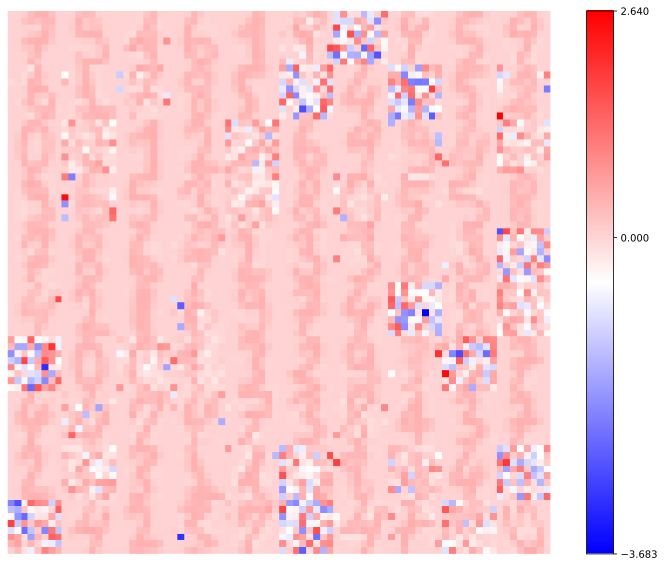

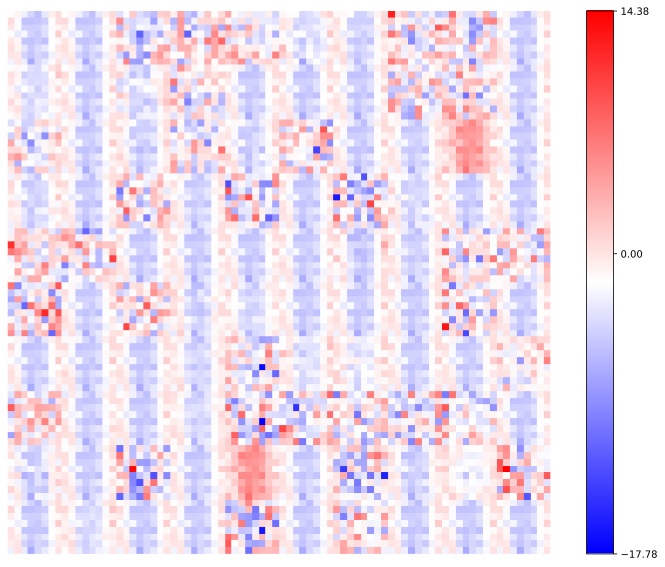

In [9]:
hid_lays = [100, 100]
fws, cwd, wd = unsuperv_multiple(x_train, y_train, hid_lays)
peek_weights_multiple(datx, daty, peekX, peekY, hid_lays, cwd)

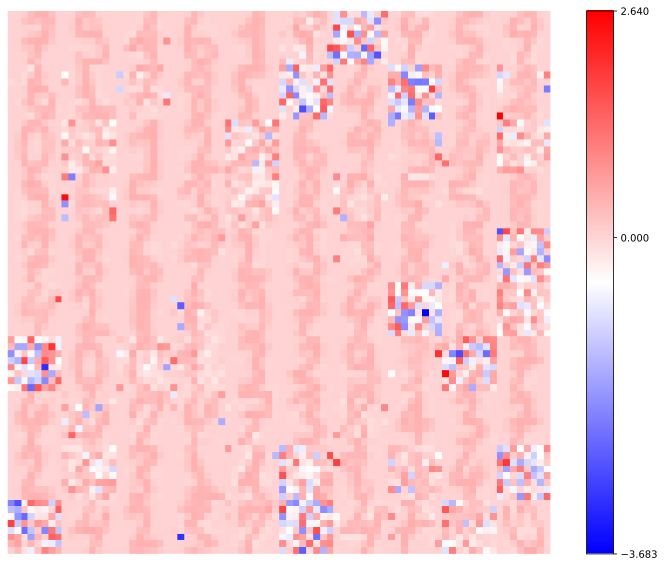

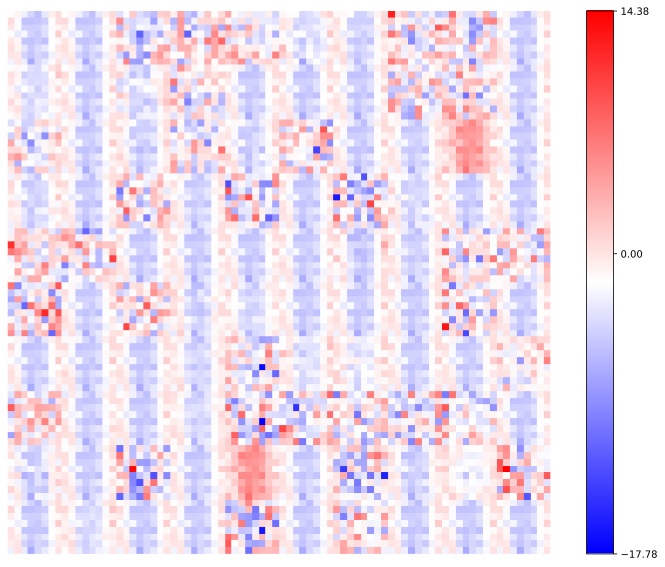

In [10]:
peek_weights_multiple(datx, daty, peekX, peekY, hid_lays, cwd)

dim x: (1617, 64)
dim y: (1617,)


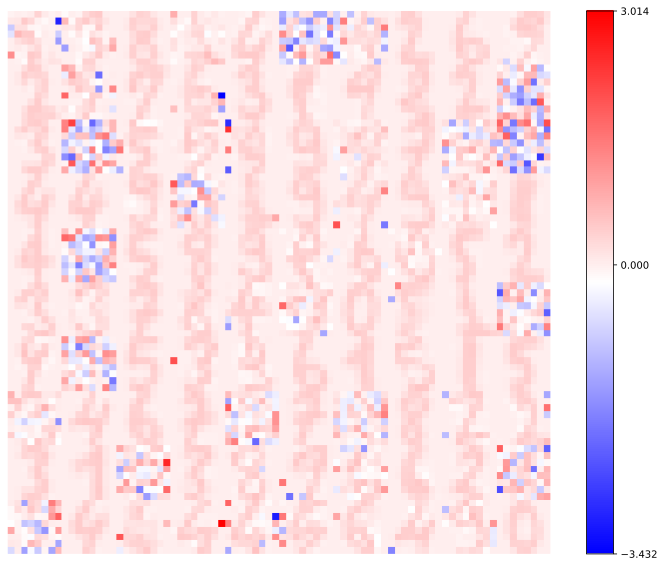

In [11]:
print(f"dim x: {np.shape(x_train)}")
print(f"dim y: {np.shape(y_train)}")
weights = unsuperv_fast(x_train, y_train, idim, dim)
peek_weights(datx, daty, peekX, peekY, weights)

In [12]:
print(torch.from_numpy(weights).size())
print(torch.from_numpy(x_train).size())
print(torch.from_numpy(y_train).size())

torch.Size([100, 64])
torch.Size([1617, 64])
torch.Size([1617])


In [13]:
def loss_torch(out, target):
    loss = torch.sum(torch.pow(torch.abs(out - target), m))
    return loss

In [14]:
def learn_final(inp_weights):
    # transform data from numpy to torch
    x_tr_torch = torch.from_numpy(x_train)
    y_tr_torch = torch.from_numpy(y_train)
    x_test_torch = torch.from_numpy(x_test)
    y_test_torch = torch.from_numpy(y_test)
    
    # one-hot encoding of the output
    target = one_hot(y_tr_torch.long())
    
    # Initialize final layer
    finlay = torch.randn(dim,odim, dtype = torch.double)
    finlay.requires_grad_()
    
    # transform final layer to torch
    midlay = torch.from_numpy(inp_weights)
    
    # start adam optimizer
    optimizer = Adam([finlay], lr = 0.001)
    
    # keep track of loss and test error rate
    loss_hist = list()
    error_rate = list()
    
    
    # iterate over epochs and batches
    for epochs in range(Nepochs):
        epoch_loss = list()
        for i in range (train_size//batch_size):
            
            # set gradients to zero
            optimizer.zero_grad()
            
            # select batch
            x_batch      = x_tr_torch[batch_size*i:batch_size*(i+1),:]
            target_batch = target[batch_size*i:batch_size*(i+1),:]
            
            # perform the matrix multiplication XW
            # have to transpose to match dimensions
            # Use relu and then take power
            h = torch.pow(relu(torch.matmul(x_batch, torch.transpose(midlay, 0, 1))), n)
    
            # perform tanh(Hy) operation
            y_pred = torch.tanh(torch.matmul(h, finlay))
            
            # compute loss
            loss = loss_torch(y_pred, target_batch)
            
            # add loss to epoch loss
            epoch_loss.append(loss.item())
            
            # backward pass
            loss.backward()
            
            # update weights
            optimizer.step()
            
        # append loss to loss history    
        loss_hist.append(sum(epoch_loss))
        
        # compute train set error
        with torch.no_grad():
            # do a forward pass
            h = torch.pow(relu(torch.matmul(x_test_torch, torch.transpose(midlay, 0, 1))), n)
            y = torch.tanh(torch.matmul(h, finlay))
            y_pred = torch.argmax(y, dim=1)
            
            # append test error rate
            correct = torch.sum((y_pred == y_test_torch).float())
            error_rate.append(correct.item() / len(y_test))
            
    return finlay, loss_hist, error_rate
    
    

In [15]:
finlay, loss_hist, error_hist = learn_final(weights)

In [16]:
finlay_mult, loss_hist_mult, error_hist_mult = learn_final(fws)

In [17]:
def test_hyperparams():
    # hyperparameters to test
    norms = (2, 3, 4, 5, 6)
    rankings = (2, 3, 4, 5, 6, 7, 8)
    deltas = (0, 0.1, 0.2, 0.3, 0.4)
    
    # initialize list of results
    results = list()
    
    for p in norms:
        for k in rankings:
            for delta in deltas:
                # initialize results for this set of hyperparams
                res = {
                    "p": p,
                    "k": k,
                    "delta":delta
                }
                
                ###### UNSUPERVISED ########
                
                # initialize weights
                weights = np.random.normal(0, 1, (dim, idim))
                
                # iterate over epochs
                for epochs in range(Nepochs):
                    
                    # linearly decaying learning rate
                    eps = epsmax*(1-epochs/Nepochs)
                    
                    # shuffle training data
#                     x_train, y_train = sklearn.utils.shuffle(x_train, y_train)
                    
                    # iterate over batches
                    for i in range (train_size//batch_size):
                        x_batch = x_train[batch_size*i:batch_size*(i+1),:]
                        
                        # Fast Implementation
                        # get currents (inner product)
                        inp_lay = vec_prod(x_batch, weights, p)

                        # get argument of highest current
                        argkey = np.argsort(inp_lay, axis = 0)#Should this be 1?
                        
                        # compute g function 
                        gfunc = np.zeros((dim, batch_size))
                        gfunc[argkey[dim-1,:], np.arange(batch_size)]=1
                        if(modified):
                            for i in range(k-1):
                                argkey[dim-1-i]
                        gfunc[argkey[dim-k-1,:], np.arange(batch_size)]= -1*delta

                        # multiply g and input layer
                        gim = np.sum(np.multiply(gfunc,inp_lay), axis = 1)

                        v = R**p*np.dot(gfunc, x_batch)-np.multiply(np.outer(gim, np.ones(idim)), weights)

                        trans = sklearn.preprocessing.MaxAbsScaler()
                        trans.fit(v)
                        weights += eps*trans.transform(v)
        
                res['midlay'] = weights
                
                ####### SUPERVISED ########
                # transform data from numpy to torch
                x_tr_torch = torch.from_numpy(x_train)
                y_tr_torch = torch.from_numpy(y_train)
                x_test_torch = torch.from_numpy(x_test)
                y_test_torch = torch.from_numpy(y_test)

                # one-hot encoding of the output
                target = one_hot(y_tr_torch)

                # Initialize final layer
                # by default, weights are drawn from a N(0,1) distribution
                finlay = torch.randn(dim,odim, dtype = torch.double)
                finlay.requires_grad_()

                # transform final layer to torch
                midlay = torch.from_numpy(weights)

                # start adam optimizer
                optimizer = Adam([finlay], lr = 0.001)

                # keep track of loss and test error rate
                loss_hist = list()
                error_rate = list()


                # iterate over epochs and batches
                for epochs in range(Nepochs):
                    epoch_loss = list()

                    # change learning rates on certain epochs
                    if epochs == 100:
                        optimizer = Adam([finlay], lr = 0.0005)
                    if epochs == 150:
                        optimizer = Adam([finlay], lr = 0.0001)
                    if epochs == 200:
                        optimizer = Adam([finlay], lr = 0.00005)
                    if epochs == 250:
                        optimizer = Adam([finlay], lr = 0.00001)

                    for i in range (train_size//batch_size):

                        # set gradients to zero
                        optimizer.zero_grad()

                        # select batch
                        x_batch      = x_tr_torch[batch_size*i:batch_size*(i+1),:]
                        target_batch = target[batch_size*i:batch_size*(i+1),:]

                        # perform the matrix multiplication XW
                        # have to transpose to match dimensions
                        # Use relu and then take power this done
                        # because the activation function is f(x) = max(0,x)^n
                        h = torch.pow(relu(torch.matmul(x_batch, torch.transpose(midlay, 0, 1))), n)

                        # perform tanh(HS) operation, where S is the final layer
                        y_pred = torch.tanh(torch.matmul(h, finlay))

                        # compute loss
                        loss = loss_torch(y_pred, target_batch)

                        # add loss to epoch loss
                        epoch_loss.append(loss.item())

                        # backward pass
                        loss.backward()

                        # update weights
                        optimizer.step()

                    # append loss to loss history    
                    loss_hist.append(sum(epoch_loss))

                    # compute train set error
                    with torch.no_grad():
                        # do a forward pass
                        h = torch.pow(relu(torch.matmul(x_test_torch, torch.transpose(midlay, 0, 1))), n)
                        y = torch.tanh(torch.matmul(h, finlay))
                        y_pred = torch.argmax(y, dim=1)

                        # append test error rate
                        correct = torch.sum((y_pred == y_test_torch).float())
                        error_rate.append(1-(correct.item() / len(y_test)))
                res['finlay'] = finlay.detach().numpy()
                res['test_error'] = error_rate
                res['loss_hist'] = loss_hist
                results.append(res)
    return res

In [ ]:
results = test_hyperparams()

with open("results.json") as f:
    f.write(json.dump(results))